In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from prince import FAMD
from scipy import sparse
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [110]:
def encoder(df, col_split):
    """
    Prepares the data for the model by standardizing the continuous features, 
    converting the categorical features to strings, 
    and converting sparse columns to a dense format for FAMD.
    """
    categorical_cols = df.columns[:col_split]

    # converting the categorical features to strings
    df[categorical_cols] = df[categorical_cols].astype(str)

    return df

def load_data(data_address='beta_dates/beta_data_7_60.csv', label_address='beta_dates/true_labels.csv'):
    df = pd.read_csv(data_address, index_col=0)
    y = pd.read_csv(label_address, index_col=0).values[:,0]
    y = y + 1
    X = encoder(df, 4)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    return X_train, X_test, y_train, y_test
def load_data_cv(data_address='beta_dates/beta_data_7_60.csv', label_address='beta_dates/true_labels.csv'):
    df = pd.read_csv(data_address, index_col=0)
    y = pd.read_csv(label_address, index_col=0).values[:,0]
    y = y + 1
    X = encoder(df, 4)

    return X, y

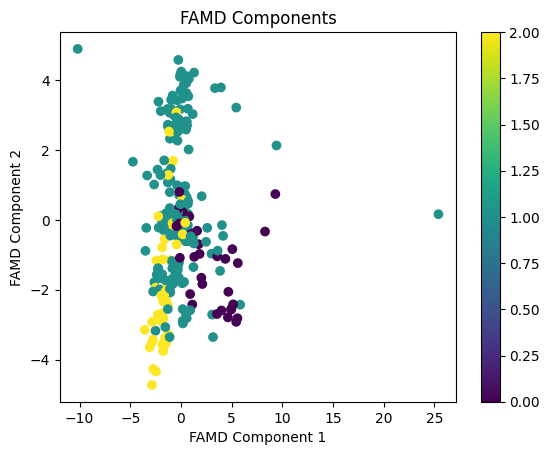

In [7]:
X, y = load_data_cv()

# Perform FAMD with 2 components
famd = FAMD(n_components=2, n_iter=10, copy=True, check_input=True, engine='sklearn', random_state=42)
famd.fit(X)
X_famd = famd.transform(X)

# Plot the first two components
plt.scatter(X_famd.iloc[:, 0], X_famd.iloc[:, 1], c=y)  # Use .iloc for DataFrame indexing
plt.xlabel('FAMD Component 1')
plt.ylabel('FAMD Component 2')
plt.title('FAMD Components')
# show the color legend
plt.colorbar()
plt.show()

# XGBoost Random Search

In [9]:
# X_train, X_test, y_train, y_test = load_data()
# # create a pipeline for XGBoost, SVD, and RandomizedSearchCV
# pipe = Pipeline([
#         ('famd', FAMD()),
#         ('xgb', xgb.XGBClassifier(objective='multi:softmax', random_state=42)),
#         ])

# # create a parameter grid for the pipeline
# param_grid = {
#         'famd__n_components': [3,4,5],
#         'xgb__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
#         'xgb__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
#         'xgb__max_depth': [5,6,7,8,9,10,11,12,13,14],
#         'xgb__n_estimators': [50,65,80,100,115,130,150],
#         'xgb__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#         'xgb__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#         'xgb__subsample': [0.5,0.6,0.7,0.8,0.9,1],
#         'xgb__colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1],
#         'xgb__min_child_weight': [0.5,1,3,5,7,9],
#               }

# # perform random search

# random_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, cv=7, scoring='accuracy', verbose=1, n_jobs=-1, n_iter=1000)
# random_search.fit(X_train, y_train)

# # train model with best parameters
# best_model = random_search.best_estimator_
# best_model.fit(X_train, y_train)

# # Predictions
# predictions = best_model.predict(X_test)

# # Evaluation
# print(classification_report(y_test, predictions))

# print(random_search.best_params_)
# print(random_search.best_score_)
# print(random_search.cv_results_)

# XGBoost Bayesian Optimization

In [74]:
X_train, X_test, y_train, y_test = load_data()

# Create a pipeline
pipe = Pipeline([
    ('svd', FAMD(n_components=3)),
    ('xgb', XGBClassifier(objective='multi:softmax', random_state=42)),
])

# Define the evaluation function
def xgb_evaluate(gamma, learning_rate, max_depth, n_estimators, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight):
    params = {
        'xgb__gamma': gamma,
        'xgb__learning_rate': learning_rate,
        'xgb__max_depth': int(max_depth),
        'xgb__n_estimators': int(n_estimators),
        'xgb__reg_alpha': reg_alpha,
        'xgb__reg_lambda': reg_lambda,
        'xgb__subsample': subsample,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__min_child_weight': min_child_weight,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return accuracy_score(y_test, predictions)

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'gamma': (0, 5),
        'learning_rate': (0.01, 0.5),
        'max_depth': (3, 5),
        'n_estimators': (50, 300),
        'reg_alpha': (10, 100),
        'reg_lambda': (10, 100),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'min_child_weight': (1, 10),
    },
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=200)

# After optimization, retrieve and adjust best parameters for pipeline
xgb_best_params = optimizer.max['params']
xgb_best_params_for_pipeline = {'xgb__' + key: int(value) if key in ['max_depth', 'n_estimators'] else value for key, value in xgb_best_params.items()}

# Set the best parameters in the pipeline
pipe.set_params(**xgb_best_params_for_pipeline)
pipe.fit(X_train, y_train)

# Predictions and Evaluation
predictions = pipe.predict(X_test)
print(classification_report(y_test, predictions))

# Print best parameters and performance
print("Best Parameters for Pipeline:", xgb_best_params_for_pipeline)
print("Best Performance:", optimizer.max['target'])



|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6812    | 0.6873    | 4.754     | 0.3687    | 4.197     | 2.404     | 89.0      | 15.23     | 87.96     | 0.8006    |
| 2         | 0.6812    | 0.854     | 0.1029    | 0.4853    | 4.665     | 2.911     | 95.46     | 26.51     | 37.38     | 0.7624    |
| 3         | 0.6812    | 0.716     | 1.456     | 0.3098    | 3.279     | 3.629     | 141.6     | 51.05     | 80.67     | 0.5998    |
| 4         | 0.1159    | 0.7571    | 2.962     | 0.03276   | 4.215     | 2.535     | 66.26     | 95.4      | 96.91     | 0.9042    |
| 5         | 0.6812    | 0.6523    | 0.4884    | 0.3453    | 3.88      | 2.098     | 173.8     | 13.09     | 91.84     | 0.6294    |
| 6         | 0.6812    | 1.0       | 5.0       | 0.01      | 

# Build the best model

{'logreg__C': 32.67792536975631, 'logreg__penalty': 'l2', 'logreg__multi_class': 'ovr', 'logreg__solver': 'saga'}


In [84]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)

# create a pipeline with the best parameters
pipe = Pipeline([
    ('xgb', XGBClassifier(objective='multi:softmax')),
])

def xgb_evaluate(gamma, learning_rate, max_depth, n_estimators, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight):
    params = {
        'xgb__gamma': gamma,
        'xgb__learning_rate': learning_rate,
        'xgb__max_depth': int(max_depth),
        'xgb__n_estimators': int(n_estimators),
        'xgb__reg_alpha': reg_alpha,
        'xgb__reg_lambda': reg_lambda,
        'xgb__subsample': subsample,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__min_child_weight': min_child_weight,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return accuracy_score(y_test, predictions)

# Perform K-Fold Cross-Validation

accuracy_scores = []
params = []
for train_index, test_index in skf.split(X, y):

    # Bayesian Optimization
    optimizer = BayesianOptimization(
        f=xgb_evaluate,
        pbounds={
            'gamma': (.1, 10),
            'learning_rate': (0.01, 1),
            'max_depth': (3, 6),
            'n_estimators': (80, 200),
            'reg_alpha': (.5, 10),
            'reg_lambda': (.5, 10),
            'subsample': (0.1, 1.0),
            'colsample_bytree': (0.1, 1.0),
            'min_child_weight': (3, 10),
        },
    )
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    optimizer.maximize(init_points=5, n_iter=200)

    # After optimization, retrieve and adjust best parameters for pipeline
    xgb_best_params = optimizer.max['params']
    xgb_best_params_for_pipeline = {'xgb__' + key: int(value) if key in ['max_depth', 'n_estimators'] else value for key, value in xgb_best_params.items()}

    # Set the best parameters in the pipeline
    pipe.set_params(**xgb_best_params_for_pipeline)
    pipe.fit(X_train, y_train)

    # Predictions and Evaluation
    predictions = pipe.predict(X_test)
    print(classification_report(y_test, predictions))

    # Print best parameters and performance
    print("Best Parameters for Pipeline:", xgb_best_params_for_pipeline)
    print("Best Performance:", optimizer.max['target'])

    accuracy_scores.append(optimizer.max['target'])
    params.append(xgb_best_params_for_pipeline)

print("Average Accuracy:", np.mean(accuracy_scores))


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6909    | 0.799     | 5.118     | 0.7581    | 3.035     | 3.152     | 85.63     | 6.167     | 3.338     | 0.4266    |
| 2         | 0.6909    | 0.3695    | 5.343     | 0.3844    | 4.442     | 6.485     | 169.7     | 3.091     | 4.758     | 0.8265    |
| 3         | 0.6909    | 0.2314    | 7.419     | 0.9844    | 3.151     | 4.872     | 158.5     | 4.085     | 3.341     | 0.5814    |
| 4         | 0.6909    | 0.8069    | 8.695     | 0.7732    | 3.893     | 9.192     | 138.6     | 2.152     | 9.269     | 0.143     |
| 5         | 0.6909    | 0.2983    | 2.899     | 0.5162    | 5.807     | 8.176     | 121.8     | 2.139     | 8.181     | 0.4427    |
| 6         | 0.6909    | 0.3455    | 1.639     | 0.7177    | 

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 6         | 0.6909    | 0.1848    | 7.601     | 0.3839    | 5.738     | 9.652     | 96.45     | 2.768     | 2.371     | 0.2001    |
| 7         | 0.7636    | 0.1857    | 0.3093    | 0.9838    | 4.376     | 6.93      | 135.9     | 3.229     | 7.909     | 0.9168    |
| 8         | 0.7818    | 0.1       | 0.1       | 1.0       | 5.577     | 6.11      | 135.6     | 1.287     | 6.783     | 1.0       |
| 9         | 0.8       | 0.1       | 0.1       | 1.0       | 6.0       | 3.139     | 132.1     | 0.5       | 8.201     | 1.0       |
| 10        | 0.7636    | 0.1       | 0.1       | 1.0       | 6.0       | 3.0       | 129.9     | 0.5       | 1.616     | 1.0       |
| 11        | 0.7636    | 0.1       | 6.503     | 1.0       | 6.0       | 3.0       | 133.7     | 0.5       | 8.354     | 1.0       |
| 12        | 0.7455    | 0.1759    | 0.8716    | 0.1454    | 3.853     | 3.435     | 122.8     | 0.779     | 9.456     | 0.6389    |
| 13        | 0.6909    | 0.6836    | 10.0      | 1.0       | 

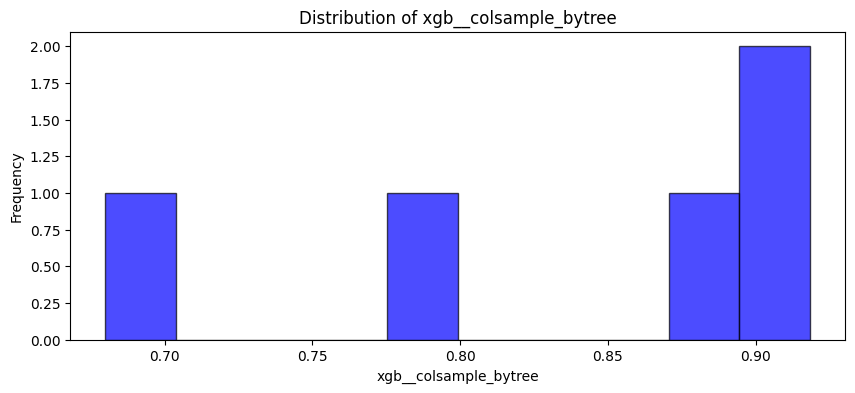

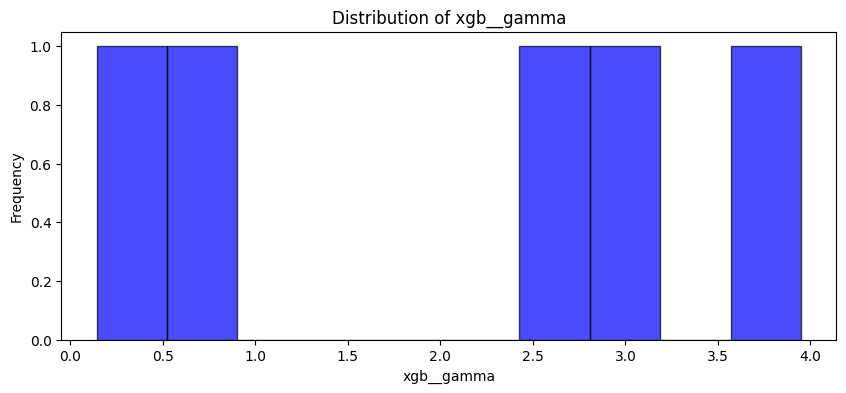

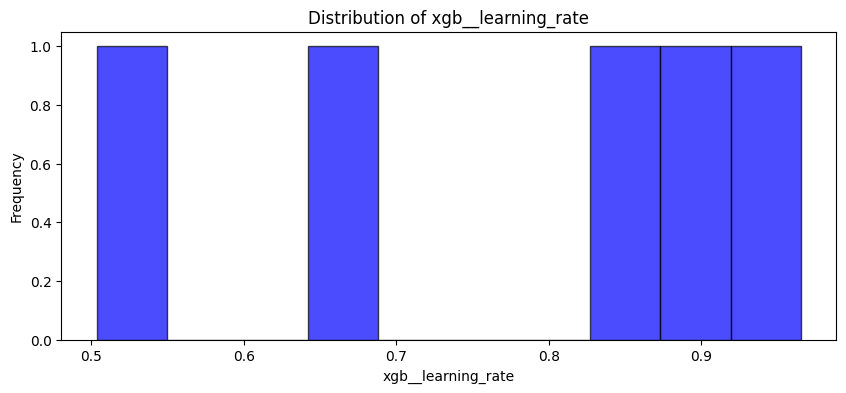

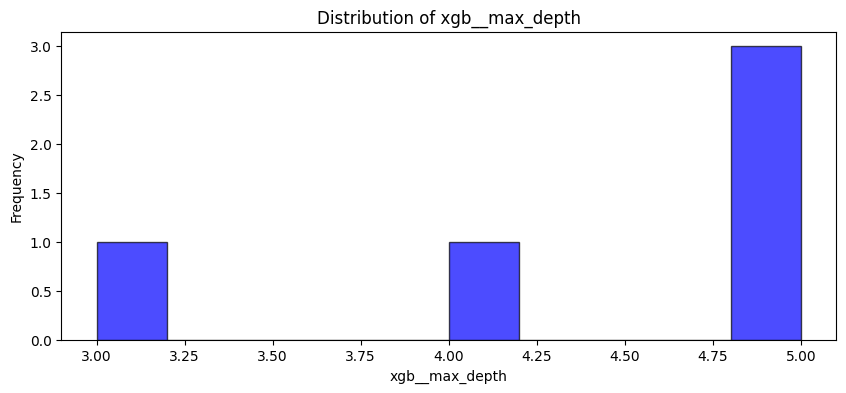

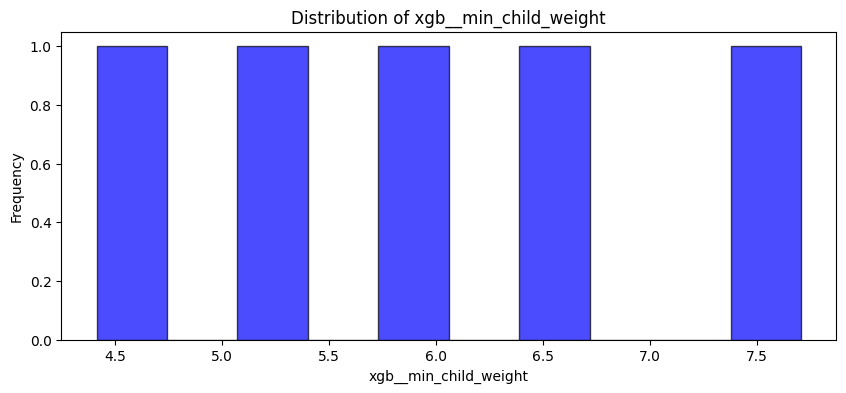

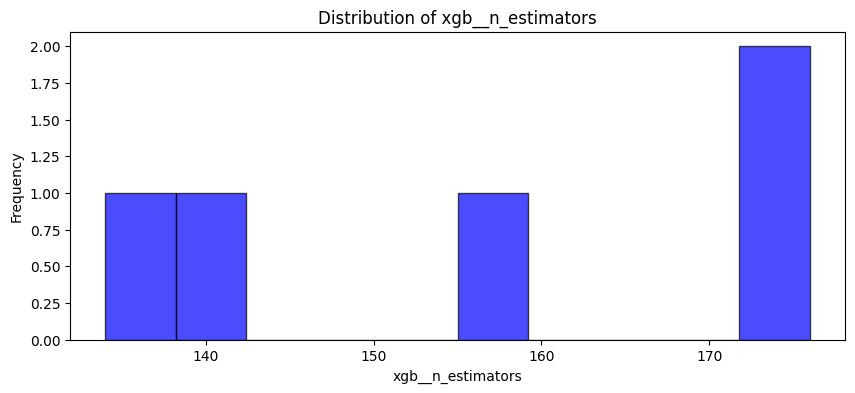

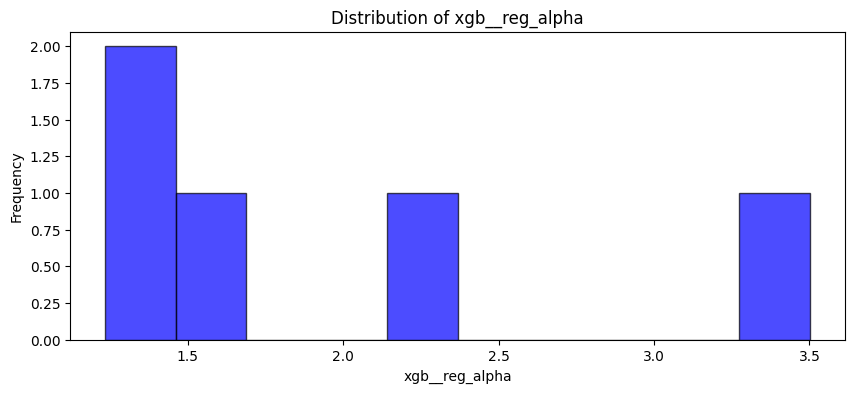

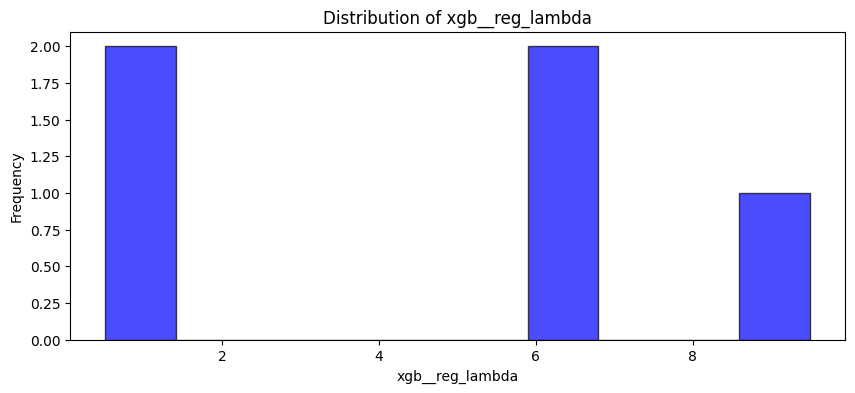

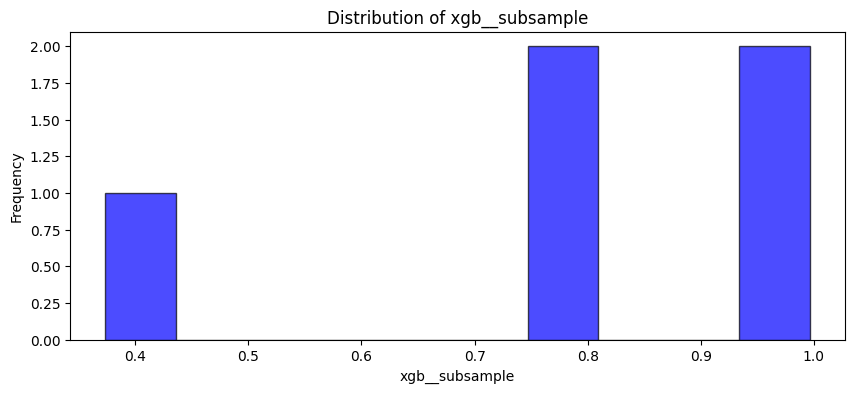

In [86]:
# create visualization of the best parameters, a visualization
param_values = {
    'xgb__colsample_bytree': [],
    'xgb__gamma': [],
    'xgb__learning_rate': [],
    'xgb__max_depth': [],
    'xgb__min_child_weight': [],
    'xgb__n_estimators': [],
    'xgb__reg_alpha': [],
    'xgb__reg_lambda': [],
    'xgb__subsample': []
}

# Populate the lists
for param_set in params:
    for param, value in param_set.items():
        param_values[param].append(value)

# Create histograms
for param, values in param_values.items():
    plt.figure(figsize=(10, 4))
    plt.hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Distribution of {param}')
    plt.xlabel(param)
    plt.ylabel('Frequency')
    plt.show()

In [89]:
# Initialize a dictionary to store the sum of each parameter
sums = {
    'xgb__colsample_bytree': 0,
    'xgb__gamma': 0,
    'xgb__learning_rate': 0,
    'xgb__max_depth': 0,
    'xgb__min_child_weight': 0,
    'xgb__n_estimators': 0,
    'xgb__reg_alpha': 0,
    'xgb__reg_lambda': 0,
    'xgb__subsample': 0
}

# Sum up the values for each parameter
for param_set in params:
    for param, value in param_set.items():
        sums[param] += value

# Calculate the mean for each parameter
means = {param: sum_val / len(params) for param, sum_val in sums.items()}

# round max_depth and n_estimators
means['xgb__max_depth'] = int(round(means['xgb__max_depth']))
means['xgb__n_estimators'] = int(round(means['xgb__n_estimators']))

print("Mean values of parameters:", means)

Mean values of parameters: {'xgb__colsample_bytree': 0.8314087089720534, 'xgb__gamma': 2.068218435894297, 'xgb__learning_rate': 0.7757676744286774, 'xgb__max_depth': 4, 'xgb__min_child_weight': 5.920879982985454, 'xgb__n_estimators': 156, 'xgb__reg_alpha': 2.0124120042376505, 'xgb__reg_lambda': 4.703662676675085, 'xgb__subsample': 0.7918852620425526}


In [106]:
avg_accuracy_scores = []
for i in range(10):
    # Number of splits for K-Fold Cross-Validation
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    X, y = load_data_cv()

    famd = FAMD(n_components=8)
    famd.fit(X)
    X = famd.transform(X)

    # create a pipeline with the best parameters
    pipe = Pipeline([
        ('xgb', XGBClassifier(objective='multi:softmax')),
    ])

    # Perform K-Fold Cross-Validation

    # set the parameters to the mean values
    pipe.set_params(**means)

    accuracy_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the pipeline to the training data
        pipe.fit(X_train, y_train)

        # Make predictions on the test set
        predictions = pipe.predict(X_test)

        # Evaluate the model
        # print(classification_report(y_test, predictions))
        # print("Accuracy:", accuracy_score(y_test, predictions))
        accuracy_scores.append(accuracy_score(y_test, predictions))

    print("Average Accuracy:", np.mean(accuracy_scores))
    avg_accuracy_scores.append(np.mean(accuracy_scores))


Average Accuracy: 0.7774410774410775
Average Accuracy: 0.7482828282828283
Average Accuracy: 0.7775084175084175
Average Accuracy: 0.791986531986532
Average Accuracy: 0.7736026936026936
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7702356902356902
Average Accuracy: 0.7771717171717172
Average Accuracy: 0.7808080808080808
Average Accuracy: 0.7884848484848486
Average Accuracy: 0.7884175084175086
Average Accuracy: 0.7847811447811448
Average Accuracy: 0.7883501683501684
Average Accuracy: 0.7884175084175086
Average Accuracy: 0.76989898989899
Average Accuracy: 0.7483501683501683
Average Accuracy: 0.7845117845117846
Average Accuracy: 0.7955555555555556
Average Accuracy: 0.7661279461279461
Average Accuracy: 0.7735353535353535
Average Accuracy: 0.7773737373737374
Average Accuracy: 0.7552861952861953
Average Accuracy: 0.7703703703703704
Average Accuracy: 0.7591919191919192
Average Accuracy: 0.7517171717171717
Average Accuracy: 0.7701010101010102
Average Accuracy: 0.7517845117845118
Aver

In [109]:
print("Average Average Accuracy:", np.mean(avg_accuracy_scores))

Average Average Accuracy: 0.7716798653198653


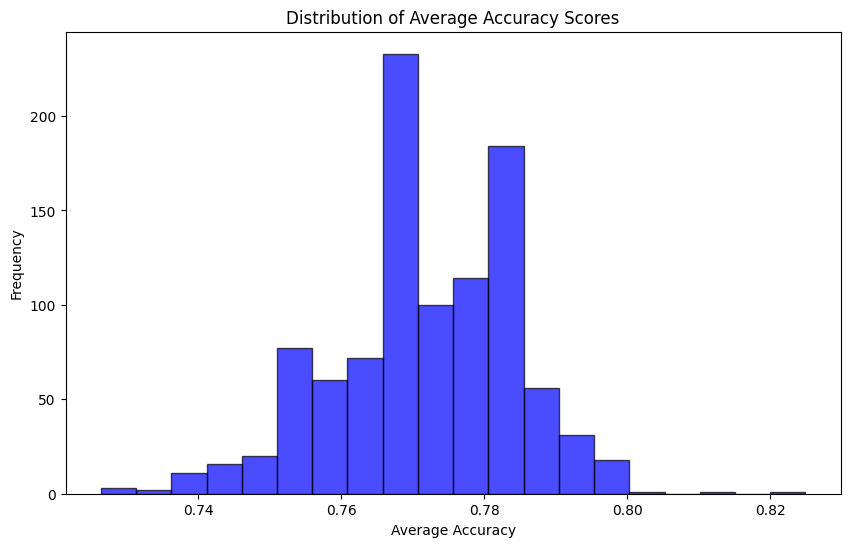

In [107]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_accuracy_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Average Accuracy Scores')
plt.xlabel('Average Accuracy')
plt.ylabel('Frequency')
plt.show()

In [123]:
import os

In [124]:
new_avg_accuracy_scores = []
# iterate for all the data files in the folder 'beta_dates
for file in os.listdir('beta_dates'):
    print(file)

    # for i in range(10):
    #     # Number of splits for K-Fold Cross-Validation
    #     n_splits = 5
    #     skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    #     X, y = load_data_cv()

    #     famd = FAMD(n_components=8)
    #     famd.fit(X)
    #     X = famd.transform(X)

    #     # create a pipeline with the best parameters
    #     pipe = Pipeline([
    #         ('xgb', XGBClassifier(objective='multi:softmax')),
    #     ])

    #     # Perform K-Fold Cross-Validation

    #     # set the parameters to the mean values
    #     pipe.set_params(**means)

    #     accuracy_scores = []
    #     for train_index, test_index in skf.split(X, y):
    #         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #         y_train, y_test = y[train_index], y[test_index]

    #         # Fit the pipeline to the training data
    #         pipe.fit(X_train, y_train)

    #         # Make predictions on the test set
    #         predictions = pipe.predict(X_test)

    #         # Evaluate the model
    #         # print(classification_report(y_test, predictions))
    #         # print("Accuracy:", accuracy_score(y_test, predictions))
    #         accuracy_scores.append(accuracy_score(y_test, predictions))

    #     print("Average Accuracy:", np.mean(accuracy_scores))
    #     new_avg_accuracy_scores.append(np.mean(accuracy_scores))
    # # Create the histogram
    # plt.figure(figsize=(10, 6))
    # plt.hist(avg_accuracy_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
    # plt.title('Distribution of Average Accuracy Scores')
    # plt.xlabel('Average Accuracy')
    # plt.ylabel('Frequency')
    # plt.show()
    # print("Average Average Accuracy:", np.mean(avg_accuracy_scores))

beta_data_2_60.csv
beta_data_7_120.csv
beta_data_2_120.csv
true_labels.csv
beta_data_7_60.csv


In [114]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv('beta_dates/beta_data_2_120.csv', 'beta_dates/true_labels.csv')

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)

# create a pipeline with the best parameters
pipe = Pipeline([
    ('rf', RandomForestClassifier()),
])

# Perform K-Fold Cross-Validation

accuracy_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))

print("Average Accuracy:", np.mean(accuracy_scores))


              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31         7
         1.0       0.73      0.84      0.78        38
         2.0       0.60      0.30      0.40        10

    accuracy                           0.67        55
   macro avg       0.55      0.48      0.50        55
weighted avg       0.65      0.67      0.65        55

Accuracy: 0.6727272727272727
              precision    recall  f1-score   support

         0.0       0.57      0.67      0.62         6
         1.0       0.79      0.82      0.81        38
         2.0       0.56      0.45      0.50        11

    accuracy                           0.73        55
   macro avg       0.64      0.65      0.64        55
weighted avg       0.72      0.73      0.72        55

Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

         0.0       0.33      0.17      0.22         6
         1.0       0.77      0.87      0.81        38
         2.0     

In [65]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)

# create a pipeline with the best parameters
pipe = Pipeline([
    ('logreg', LogisticRegression(max_iter=1000, multi_class='multinomial')),
])
# Perform K-Fold Cross-Validation

accuracy_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))

print("Average Accuracy:", np.mean(accuracy_scores))


              precision    recall  f1-score   support

         0.0       0.67      0.29      0.40         7
         1.0       0.81      0.89      0.85        38
         2.0       0.70      0.70      0.70        10

    accuracy                           0.78        55
   macro avg       0.73      0.63      0.65        55
weighted avg       0.77      0.78      0.77        55

Accuracy: 0.7818181818181819
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60         6
         1.0       0.80      0.87      0.84        38
         2.0       0.60      0.55      0.57        11

    accuracy                           0.76        55
   macro avg       0.72      0.64      0.67        55
weighted avg       0.76      0.76      0.76        55

Accuracy: 0.7636363636363637
              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77         6
         1.0       0.84      0.82      0.83        38
         2.0     

In [14]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)
imputer = SimpleImputer(strategy='mean')
# Perform K-Fold Cross-Validation

pipe = Pipeline([
        ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('qda', QuadraticDiscriminantAnalysis()),
    ])
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       0.45      0.71      0.56         7
         1.0       0.82      0.61      0.70        38
         2.0       0.44      0.70      0.54        10

    accuracy                           0.64        55
   macro avg       0.57      0.67      0.60        55
weighted avg       0.70      0.64      0.65        55

Accuracy: 0.6363636363636364
              precision    recall  f1-score   support

         0.0       0.80      0.67      0.73         6
         1.0       0.85      0.61      0.71        38
         2.0       0.39      0.82      0.53        11

    accuracy                           0.65        55
   macro avg       0.68      0.70      0.65        55
weighted avg       0.75      0.65      0.67        55

Accuracy: 0.6545454545454545
              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57         6
         1.0       0.73      0.63      0.68        38
         2.0     

In [51]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=8)
famd.fit(X)
X = famd.transform(X)
imputer = SimpleImputer(strategy='mean')
# Perform K-Fold Cross-Validation

pipe = Pipeline([
        ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('lda', LinearDiscriminantAnalysis()),
    ])
accuracy_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       0.75      0.43      0.55         7
         1.0       0.79      0.87      0.82        38
         2.0       0.56      0.50      0.53        10

    accuracy                           0.75        55
   macro avg       0.70      0.60      0.63        55
weighted avg       0.74      0.75      0.74        55

Accuracy: 0.7454545454545455
              precision    recall  f1-score   support

         0.0       0.43      0.50      0.46         6
         1.0       0.90      0.74      0.81        38
         2.0       0.59      0.91      0.71        11

    accuracy                           0.75        55
   macro avg       0.64      0.72      0.66        55
weighted avg       0.79      0.75      0.75        55

Accuracy: 0.7454545454545455
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60         6
         1.0       0.76      0.84      0.80        38
         2.0     

In [16]:
# X_train, X_test, y_train, y_test = load_data()
# # create a pipeline for XGBoost, FAMD, Random Forests, and Multiclass logistic regression
# pipe = Pipeline([
#         ('svd', FAMD()),
#         ('xgb', XGBClassifier(objective='multi:softmax', random_state=42)),
#         ])

# # create a parameter grid for the pipeline

# param_grid = {
# 'svd__n_components': 5,
#  'xgb__colsample_bytree': 0.8, 
#  'xgb__gamma': 0.5, 
#  'xgb__learning_rate': 0.1,
#    'xgb__max_depth': 3, 
#    'xgb__min_child_weight': 2, 
#    'xgb__n_estimators': 200, 
#    'xgb__reg_alpha': 10, 
#    'xgb__reg_lambda': 20, 
#    'xgb__subsample': 0.7}


# pipe.fit(X_train, y_train).score(X_test, y_test)

# pipe.set_params(**param_grid).fit(X_train, y_train).score(X_test, y_test)

# # Predictions
# predictions = pipe.predict(X_test)

# # Evaluation
# print(classification_report(y_test, predictions))

# Random Forest Bayesian Search

In [17]:
X_train, X_test, y_train, y_test = load_data()

# Create a pipeline for Random Forests
pipe = Pipeline([
    ('famd', FAMD()),
    ('rf', RandomForestClassifier()),
])

# Define the evaluation function
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    params = {
        'rf__n_estimators': int(n_estimators),
        'rf__max_depth': int(max_depth),
        'rf__min_samples_split': int(min_samples_split),
        'rf__min_samples_leaf': int(min_samples_leaf),
        'rf__max_features': max_features,
    }
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return accuracy_score(y_test, predictions)

# Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds={
        'n_estimators': (50, 300),
        'max_depth': (3, 5),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': (0.1,1)
    },
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=200)

# After optimization, retrieve and adjust best parameters for pipeline
xgb_best_params = optimizer.max['params']
best_params_for_pipeline = {'rf__' + key: int(value) if key in ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf'] else value for key, value in xgb_best_params.items()}

# Set the best parameters in the pipeline
pipe.set_params(**best_params_for_pipeline)
pipe.fit(X_train, y_train)

# Predictions and Evaluation
predictions = pipe.predict(X_test)
print(classification_report(y_test, predictions))

# Print best parameters and performance
print("Best Parameters for Pipeline:", best_params_for_pipeline)
print("Best Performance:", optimizer.max['target'])



|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.7826    | 3.749     | 0.9556    | 3.196     | 6.789     | 89.0      |
| 2         | 0.7826    | 3.312     | 0.1523    | 3.599     | 6.809     | 227.0     |
| 3         | 0.7681    | 3.041     | 0.9729    | 3.497     | 3.699     | 95.46     |
| 4         | 0.7826    | 3.367     | 0.3738    | 2.574     | 5.456     | 122.8     |
| 5         | 0.7826    | 4.224     | 0.2255    | 1.876     | 4.931     | 164.0     |
| 6         | 0.7826    | 3.152     | 0.2818    | 2.973     | 5.548     | 122.7     |
| 7         | 0.7681    | 3.483     | 0.6423    | 2.23      | 8.99      | 83.2      |
| 8         | 0.7826    | 4.564     | 0.1       | 1.74      | 6.177     | 118.2     |
| 9         | 0.7826    | 4.074     | 0.7616    | 1.916     | 9.875     | 121.5     |
| 10        | 0.7826    | 4.563     | 0.2015    | 3.94

# Logistic Regression Bayesian Optimization

In [50]:
# # Assume load_data function and dataset are defined
# X_train, X_test, y_train, y_test = load_data()

# # Create a pipeline for Logistic Regression
# pipe = Pipeline([
#     ('svd', TruncatedSVD(n_components=5)),
#     ('logreg', LogisticRegression(max_iter=1000)),  # Increased max_iter for convergence
# ])

# penalties = ['l2']
# multi_classes = ['ovr', 'multinomial']
# solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']

# # Define the evaluation function
# def logreg_evaluate(C, penalty, multi_class, solver):
#     penalty = penalties[int(penalty)]
#     multi_class = multi_classes[int(multi_class)]
#     solver = solvers[int(solver)]

#     params = {
#         'logreg__C': C,
#         'logreg__penalty': penalty,
#         'logreg__multi_class': multi_class,
#         'logreg__solver': solver,
#     }
#     pipe.set_params(**params)
#     pipe.fit(X_train, y_train)
#     predictions = pipe.predict(X_test)
#     return accuracy_score(y_test, predictions)

# # Bayesian Optimization
# optimizer = BayesianOptimization(
#     f=logreg_evaluate,
#     pbounds={
#         'C': (0.1, 100),
#         'penalty': (0, len(penalties) - 1),  # Ensuring valid index range
#         'multi_class': (0, len(multi_classes) - 1),  # Ensuring valid index range
#         'solver': (0, len(solvers) - 1),  # Ensuring valid index range
#     },
#     random_state=42
# )

# optimizer.maximize(init_points=5, n_iter=200)

# # After optimization, retrieve and adjust best parameters for pipeline
# best_params = optimizer.max['params']
# best_params_for_pipeline = {
#     'logreg__C': best_params['C'],
#     'logreg__penalty': penalties[int(best_params['penalty'])],
#     'logreg__multi_class': multi_classes[int(best_params['multi_class'])],
#     'logreg__solver': solvers[int(best_params['solver'])],
# }

# # Set the best parameters in the pipeline
# pipe.set_params(**best_params_for_pipeline)
# pipe.fit(X_train, y_train)

# # Predictions and Evaluation
# predictions = pipe.predict(X_test)
# print(classification_report(y_test, predictions))

# # Print best parameters and performance
# print("Best Parameters for Pipeline:", best_params_for_pipeline)
# print("Best Performance:", optimizer.max['target'])


In [45]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

X, y = load_data_cv()

famd = FAMD(n_components=2)
famd.fit(X)
X = famd.transform(X)
imputer = SimpleImputer(strategy='mean')

pipe = Pipeline([
        ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('lda', LinearDiscriminantAnalysis()),
    ])

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       1.00      0.29      0.44         7
         1.0       0.77      0.95      0.85        38
         2.0       0.67      0.40      0.50        10

    accuracy                           0.76        55
   macro avg       0.81      0.54      0.60        55
weighted avg       0.78      0.76      0.73        55

Accuracy: 0.7636363636363637
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.76      0.89      0.82        38
         2.0       0.57      0.36      0.44        11

    accuracy                           0.73        55
   macro avg       0.66      0.53      0.57        55
weighted avg       0.71      0.73      0.70        55

Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.80      0.97      0.88        38
         2.0     

In [21]:
# Number of splits for K-Fold Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

X, y = load_data_cv()

famd = FAMD(n_components=5, random_state=42)
famd.fit(X)
X = famd.transform(X)
imputer = SimpleImputer(strategy='mean')

pipe = Pipeline([
        ('imputer', imputer),  # Impute any NaNs that might be produced by FAMD
        ('qda', QuadraticDiscriminantAnalysis()),
    ])

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline to the training data
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipe.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

         0.0       0.29      0.29      0.29         7
         1.0       0.79      0.68      0.73        38
         2.0       0.40      0.60      0.48        10

    accuracy                           0.62        55
   macro avg       0.49      0.52      0.50        55
weighted avg       0.65      0.62      0.63        55

Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         6
         1.0       0.84      0.82      0.83        38
         2.0       0.57      0.73      0.64        11

    accuracy                           0.75        55
   macro avg       0.64      0.63      0.62        55
weighted avg       0.75      0.75      0.74        55

Accuracy: 0.7454545454545455
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44         6
         1.0       0.78      0.74      0.76        38
         2.0     